In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

dir_path = os.path.abspath(os.path.join(os.path.dirname(__file__), "..", ".."))

print(dir_path)

In [ ]:
df_translated = pd.read_csv(dir_path + "/Data/df_translated.csv")

# Text columns as before
text_columns = [
    'text',
    'title',
    'lead',
    'background',
    'outcomes',
    'targetGroup',
    'keyExpectedResults',
    'keyPreviousResults'
]

# non-empty counts for each text column
non_empty_counts = (
    df_translated[text_columns]
    .apply(lambda col: col.astype(str).str.strip().replace("nan", pd.NA).dropna().shape[0])
    .reset_index()
)
non_empty_counts.columns = ['input_column', 'n_non_empty']

# funding for each text column (sum of 'CH_Disbursement' for each project)
funding_counts = []
for col in text_columns:
    relevant_rows = df_translated[df_translated[col].notna()]
    total_funding = relevant_rows['CH_Disbursement'].sum() / 1_000_000 
    funding_counts.append({"input_column": col, "total_ODA_funding": total_funding})


funding_df = pd.DataFrame(funding_counts)

# relevant counts for each text column
relevant_counts = []

for col in text_columns:
    file_path = f"{dir_path +"/Data/Alternatives/"}descriptives_all_years_{col}.csv"
    df = pd.read_csv(file_path, dtype={"project_numbers": float})
    total_relevant = df["no_projects"].sum()
    relevant_counts.append({"input_column": col, "relevant_projects": total_relevant})

# Create a DataFrame for the relevant projects information
relevant_df = pd.DataFrame(relevant_counts)

# Step 4: Merge the non-empty counts, relevant projects, and total funding into one DataFrame
overview_df = non_empty_counts.merge(relevant_df, on="input_column")
overview_df = overview_df.merge(funding_df, on="input_column")

# Step 5: Calculate the percentage of relevant projects (optional)
overview_df["pct_relevant"] = (overview_df["relevant_projects"] / overview_df["n_non_empty"]) * 100

# Step 6: Display the result
pd.set_option("display.float_format", "{:,.2f}".format)
print(overview_df)

# Convert the DataFrame to LaTeX format (including total funding in millions)
latex_table = overview_df.to_latex(index=False, float_format="%.2f", caption="Overview of relevant projects with funding")

# Print the LaTeX code
print(latex_table)


         input_column  n_non_empty  relevant_projects  total_ODA_funding  \
0                text         5525                522          28,837.34   
1               title         5375                331          28,167.95   
2                lead         4525                519          26,714.81   
3          background         4242                447          16,280.88   
4            outcomes         3624                347          13,940.65   
5         targetGroup         4163                186          15,693.49   
6  keyExpectedResults         2677                229           9,819.28   
7  keyPreviousResults         2960                254          12,590.20   

   pct_relevant  
0          9.45  
1          6.16  
2         11.47  
3         10.54  
4          9.58  
5          4.47  
6          8.55  
7          8.58  
\begin{table}
\caption{Overview of relevant projects with funding}
\begin{tabular}{lrrrr}
\toprule
input_column & n_non_empty & relevant_projects & total

In [ ]:
# List of text columns
text_columns = ['text','title', 'lead', 'background', 'outcomes', 'targetGroup', 'keyExpectedResults', 'keyPreviousResults']

merged_data = []

for col in text_columns:
    file_path = f"{dir_path +"/Data/Alternatives/"}descriptives_all_years_{col}.csv"
    df = pd.read_csv(file_path, dtype={"project_numbers": float})
    # relevant columns
    df = df[['climate_class_number', 'climate_class', 'meta_category', 'no_projects', 'effective_funding']]
    df['input_column'] = col
    merged_data.append(df)

# Concatenate the data into one DataFrame
full_data = pd.concat(merged_data, ignore_index=True)

full_data['effective_funding']= full_data['effective_funding']/1000000
full_data['climate_class'] = full_data['climate_class'].str.replace('-', ' ', regex=False)
full_data['climate_class'] = full_data['climate_class'].str.replace('_', ' ', regex=False)

# Preview the full merged data
print(full_data)

    climate_class_number               climate_class meta_category  \
0                      0                  Adaptation    Adaptation   
1                      1                Solar energy    Mitigation   
2                      2                   Bioenergy    Mitigation   
3                      3   Other mitigation projects    Mitigation   
4                      4                Biodiversity   Environment   
..                   ...                         ...           ...   
79                     6         Nature conservation   Environment   
80                     7  Other environment projects   Environment   
81                     8        Sustainable land use   Environment   
82                    11                Hydro energy    Mitigation   
83                    12           Energy efficiency    Mitigation   

    no_projects  effective_funding        input_column  
0           298           1,111.24                text  
1            19              68.20           

In [ ]:
columns_to_keep = ['input_column', 'n_non_empty', 'total_ODA_funding']
overview_selected = overview_df[columns_to_keep]
merged_df = pd.merge(overview_selected, full_data, on="input_column", how="left")
pd.set_option("display.float_format", "{:,.2f}".format)
print(merged_df)
latex_table = merged_df.to_latex(index=False, float_format="%.2f", caption="Merged Overview of Projects with Funding Details")

# LaTeX code
print(latex_table)


          input_column  n_non_empty  total_ODA_funding  climate_class_number  \
0                 text         5525          28,837.34                     0   
1                 text         5525          28,837.34                     1   
2                 text         5525          28,837.34                     2   
3                 text         5525          28,837.34                     3   
4                 text         5525          28,837.34                     4   
..                 ...          ...                ...                   ...   
79  keyPreviousResults         2960          12,590.20                     6   
80  keyPreviousResults         2960          12,590.20                     7   
81  keyPreviousResults         2960          12,590.20                     8   
82  keyPreviousResults         2960          12,590.20                    11   
83  keyPreviousResults         2960          12,590.20                    12   

                 climate_class meta_cat

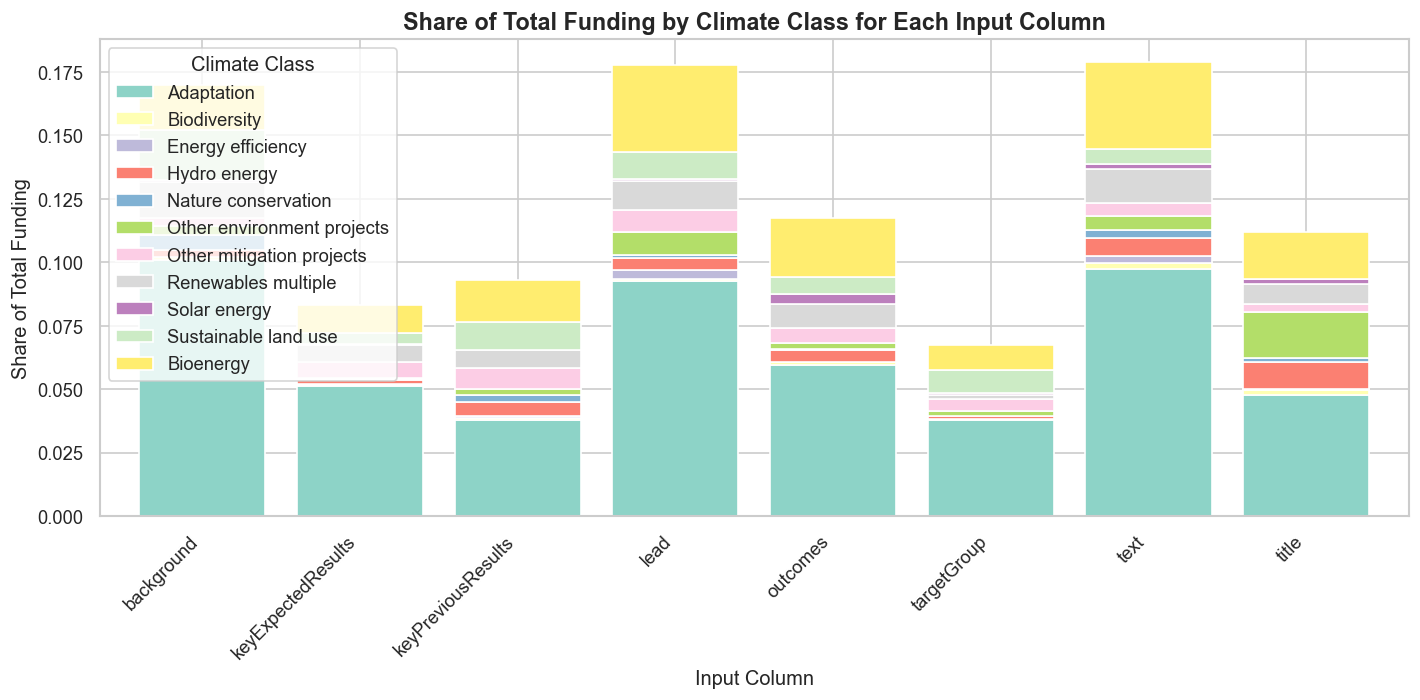

In [ ]:
# Share of effective funding for each climate_class and input_column
funding_by_class = merged_df.groupby(['input_column', 'climate_class'])['effective_funding'].sum().reset_index()

# total funding across all input columns to normalize shares
total_funding = merged_df['effective_funding'].sum()
funding_by_class['funding_share'] = funding_by_class['effective_funding'] / total_funding

pivot_data = funding_by_class.pivot_table(
    index='input_column', 
    columns='climate_class', 
    values='funding_share', 
    aggfunc='sum', 
    fill_value=0
)

#colors
unique_climate_classes = funding_by_class['climate_class'].unique()
colors = plt.cm.get_cmap("Set3", len(unique_climate_classes))

# bar plot
pivot_data.plot(
    kind='bar', 
    stacked=True,  # This makes the bars stacked
    color=colors(range(len(unique_climate_classes))),  # Use the color map
    width=0.8, 
    figsize=(12, 6)
)

plt.title("Share of Total Funding by Climate Class for Each Input Column", fontsize=14, weight='bold')
plt.xlabel("Input Column", fontsize=12)
plt.ylabel("Share of Total Funding", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Climate Class', labels=unique_climate_classes)
plt.show()


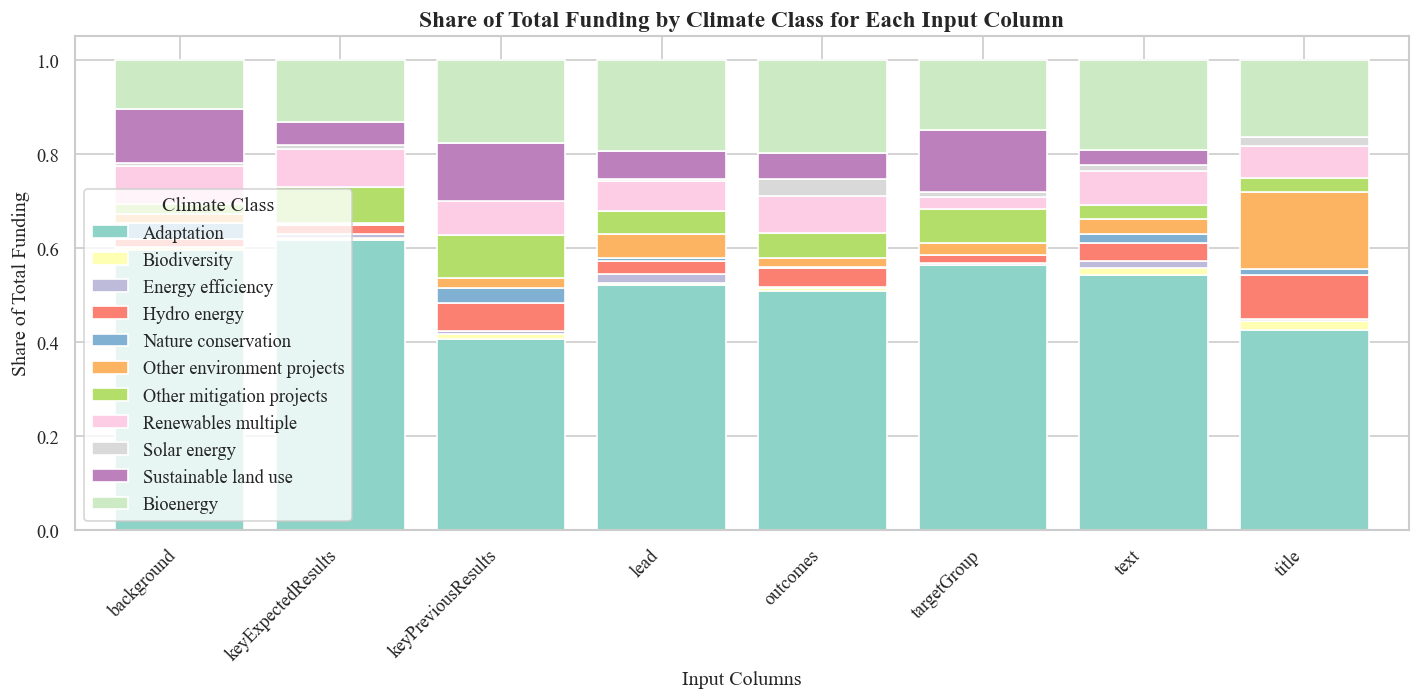

<Figure size 720x480 with 0 Axes>

In [ ]:
merged_df['normalized_funding'] = merged_df.groupby('input_column')['effective_funding'].transform(
    lambda x: x / x.sum()
)

stacked_data = merged_df.pivot_table(
    index='input_column',
    columns='climate_class',
    values='normalized_funding',
    aggfunc='sum', 
    fill_value=0  
)

# bar plot
ax = stacked_data.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 6), 
    color=sns.color_palette("Set3", len(stacked_data.columns)),
    width=0.8
)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.title("Share of Total Funding by Climate Class for Each Input Column", fontsize=14, weight='bold')
plt.xlabel("Input Columns", fontsize=12)
plt.ylabel("Share of Total Funding", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Climate Class', labels=unique_climate_classes)
plt.show()
plt.savefig("Figure6a.png", dpi=300, bbox_inches='tight')



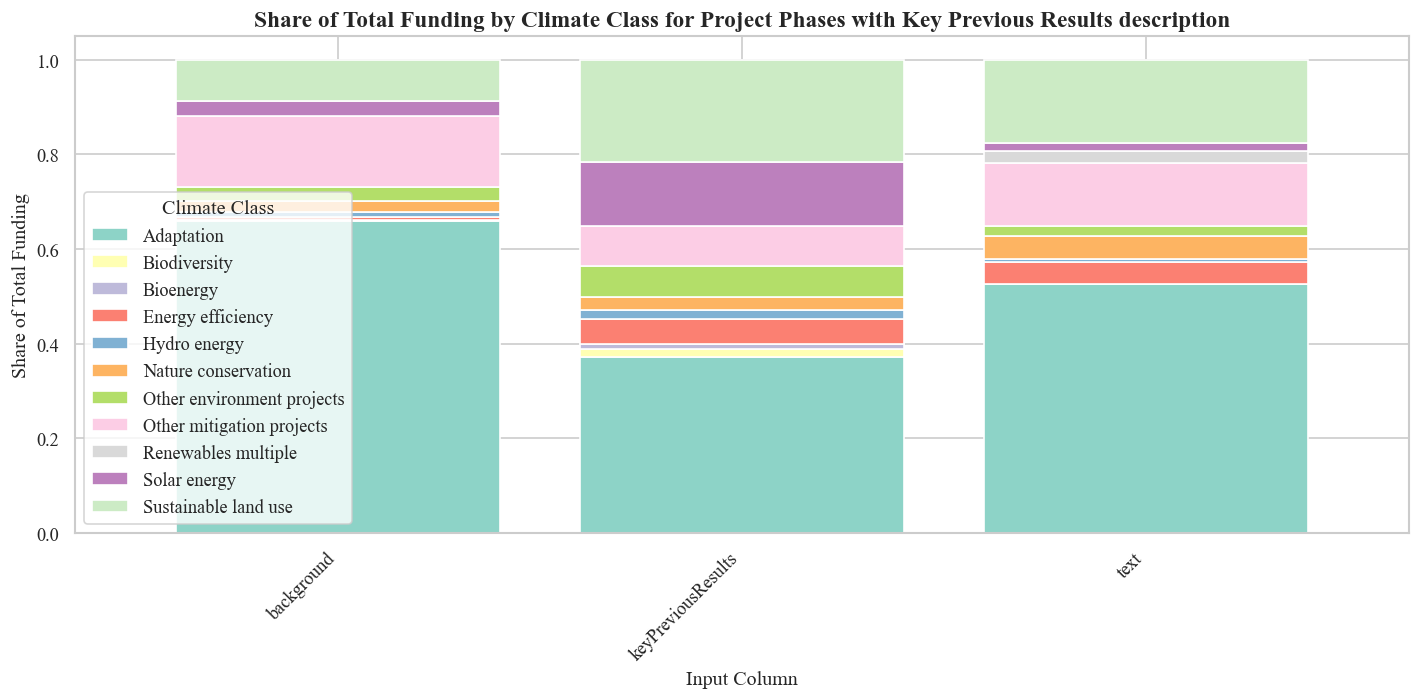

In [ ]:
# filter the 'keyPreviousResults' dataset
df_prev = pd.read_csv(dir_path +"/Data/Alternatives/" + "climate_finance_total_keyPreviousResults.csv", delimiter="|", encoding="utf-8")
df_prev['project_phase'] = df_prev['projectno'].astype(str) + "_" + df_prev['phase'].astype(str)
df_prev = df_prev[df_prev['climate_relevance'] == 1]  
df_prev = df_prev.drop_duplicates(subset='project_phase', keep='first')
relevant_keys = set(df_prev['project_phase'])
df_prev['input_column'] = "keyPreviousResults"

# filter the 'background' and 'text' datasets
def load_and_filter(filename, label):
    df = pd.read_csv(dir_path +"/Data/Alternatives/" + filename, delimiter="|", encoding="utf-8")
    df['project_phase'] = df['projectno'].astype(str) + "_" + df['phase'].astype(str)
    df = df[df['project_phase'].isin(relevant_keys)]
    df = df[df['climate_relevance'] == 1]  
    df['input_column'] = label
    return df[['project_phase', 'climate_class', 'CH_Disbursement', 'input_column']]

df_bg = load_and_filter("climate_finance_total_background.csv", "background")
df_text = load_and_filter("climate_finance_total_text.csv", "text")

# merge the filtered data
merged_df = pd.concat([df_bg, df_text, df_prev], ignore_index=True)
merged_df['climate_class'] = merged_df['climate_class'].str.replace('-', ' ', regex=False)
merged_df['climate_class'] = merged_df['climate_class'].str.replace('_', ' ', regex=False)

# normalized effective funding by input_column group
merged_df['effective_funding'] = merged_df['CH_Disbursement'] / 1_000_000  # Convert to millions
merged_df['normalized_funding'] = merged_df.groupby('input_column')['effective_funding'].transform(
    lambda x: x / x.sum()
)

for col in merged_df['climate_class'].unique():
    if col not in stacked_data.columns:
        stacked_data[col] = 0

stacked_data = merged_df.pivot_table(
    index='input_column',
    columns='climate_class',
    values='normalized_funding',
    aggfunc='sum',
    fill_value=0
)

stacked_data = stacked_data[sorted(stacked_data.columns)]

# bar plot
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'
ax = stacked_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=sns.color_palette("Set3", len(stacked_data.columns)),
    width=0.8
)
plt.title("Share of Total Funding by Climate Class for Project Phases Key Previous Results Description", fontsize=14, weight='bold')
plt.xlabel("Input Columns", fontsize=12)
plt.ylabel("Share of Total Funding", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Climate Class')
plt.tight_layout()
plt.show()
plt.savefig("Figure6b.png", dpi=300, bbox_inches='tight')

